In [1]:
# Import relevant libraries
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

In [2]:
# Get the dataset and checking its first rows
df_train = pd.read_excel(r'Train.xlsx')
df_train.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


## Data Exploration

In [3]:
# Checking data types and nulls in the dataset --> see there are no nulls
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [4]:
# Birthday is type object, so we're transforming it to type datetime
# For that we must first fix the problem of having February 29 for non-leap years --> turn all February 29 to February 28
from datetime import datetime

df_train['Birthday']=df_train['Birthday'].map(lambda x: x.replace("February 29", "February 28"))

# Check if the replacement worked
df_train['Birthday'][df_train['Birthday'].str.contains("February 29")]

Series([], Name: Birthday, dtype: object)

In [5]:
# Change the format the date appears and the data type to datetime
df_train['Birthday']=df_train['Birthday'].map(lambda x: datetime.strptime(x, " %B %d,%Y").date())
df_train['Birthday'] = pd.to_datetime(df_train['Birthday'])

In [6]:
# Get a descriptive overview of the variables (both numeric and categorical)
df_train.describe(include="all")

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400,22400,22400,22400,22400,22400,22400,22400.000000,22400,22400,22400.000000,22400.000000,22400.000000,22400.000000
unique,NaN,16074,11229,5,7,6,40,16,NaN,9,15,NaN,NaN,NaN,NaN
top,NaN,Mr. Victor Powell,2025-08-15 00:00:00,Europe,Married,Wife,Northbury,Professional School,NaN,Private Sector - Services,Professor,NaN,NaN,NaN,NaN
freq,NaN,4,9,19111,10219,9012,20074,7232,NaN,15599,2849,NaN,NaN,NaN,NaN
first,NaN,NaN,1958-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2031-10-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,23685.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.173884,NaN,NaN,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.512451,NaN,NaN,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,NaN,40.000000,0.000000,0.000000,0.000000


In [7]:
# Define Citizen_ID as the index
df_train.set_index("CITIZEN_ID", inplace=True)

# Define Income variable as the target and remove it from the dataframe with the independent variables
target = df_train['Income']
df_train = df_train.drop(['Income'], axis=1)

# Define metric and non-metric datasets
metric= df_train.loc[:, np.array(df_train.dtypes=="int64")]
non_metric= df_train.loc[:,np.array(df_train.dtypes=="object")]

In [8]:
# Get only the year from Birthday, so as to get a better visualization of the values
metric['Birthday']=df_train.Birthday.map(lambda x: x.year)

# Remove Name from the list of non_metric variables since that gives us no meaning or valuable information and plotting it would be useless
non_metric.drop(columns="Name", inplace=True)

<ipython-input-8-86cd2c956a35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric['Birthday']=df_train.Birthday.map(lambda x: x.year)
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


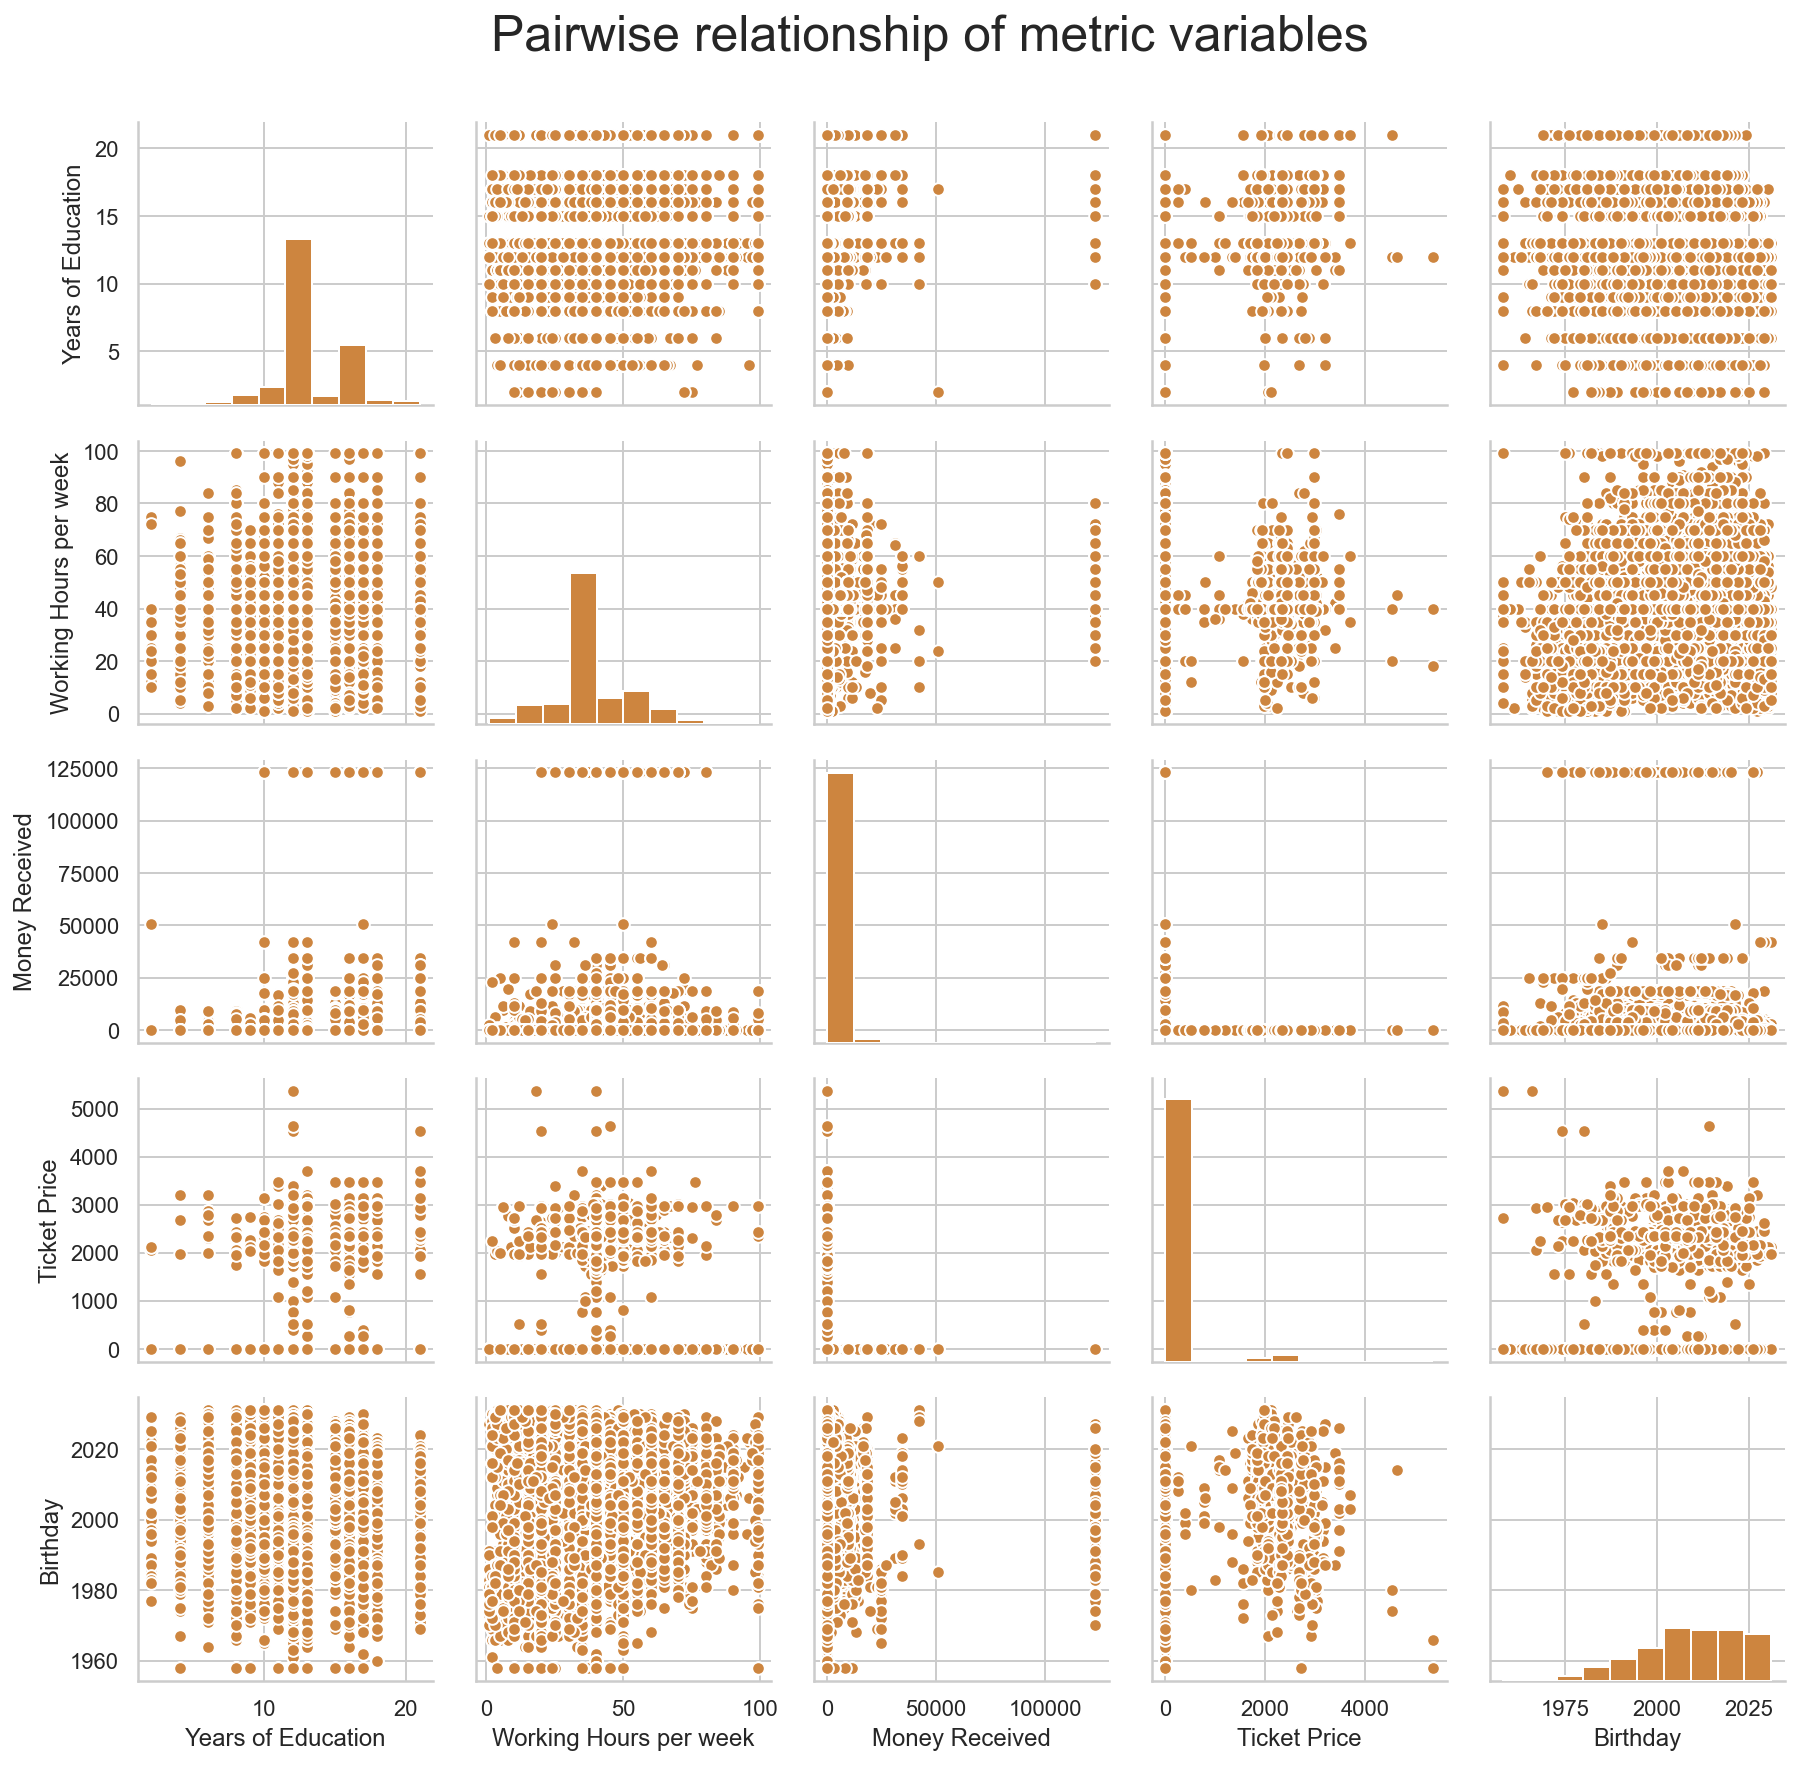

In [9]:
# Checking metrics variables' distribution and pairwise relationship
sns.set(style="whitegrid")

# Setting pairgrid
g = sns.PairGrid(metric)

# Populating pairgrid
mdg = g.map_diag(plt.hist, edgecolor="w", color="peru")
mog = g.map_offdiag(plt.scatter, edgecolor="w", color="peru", s=40)
    
# Layout
plt.subplots_adjust(top=0.92)
plt.suptitle("Pairwise relationship of metric variables", fontsize=25)

plt.show()

/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

Text(0.5, 0.98, 'Distribution of non-metric variables')

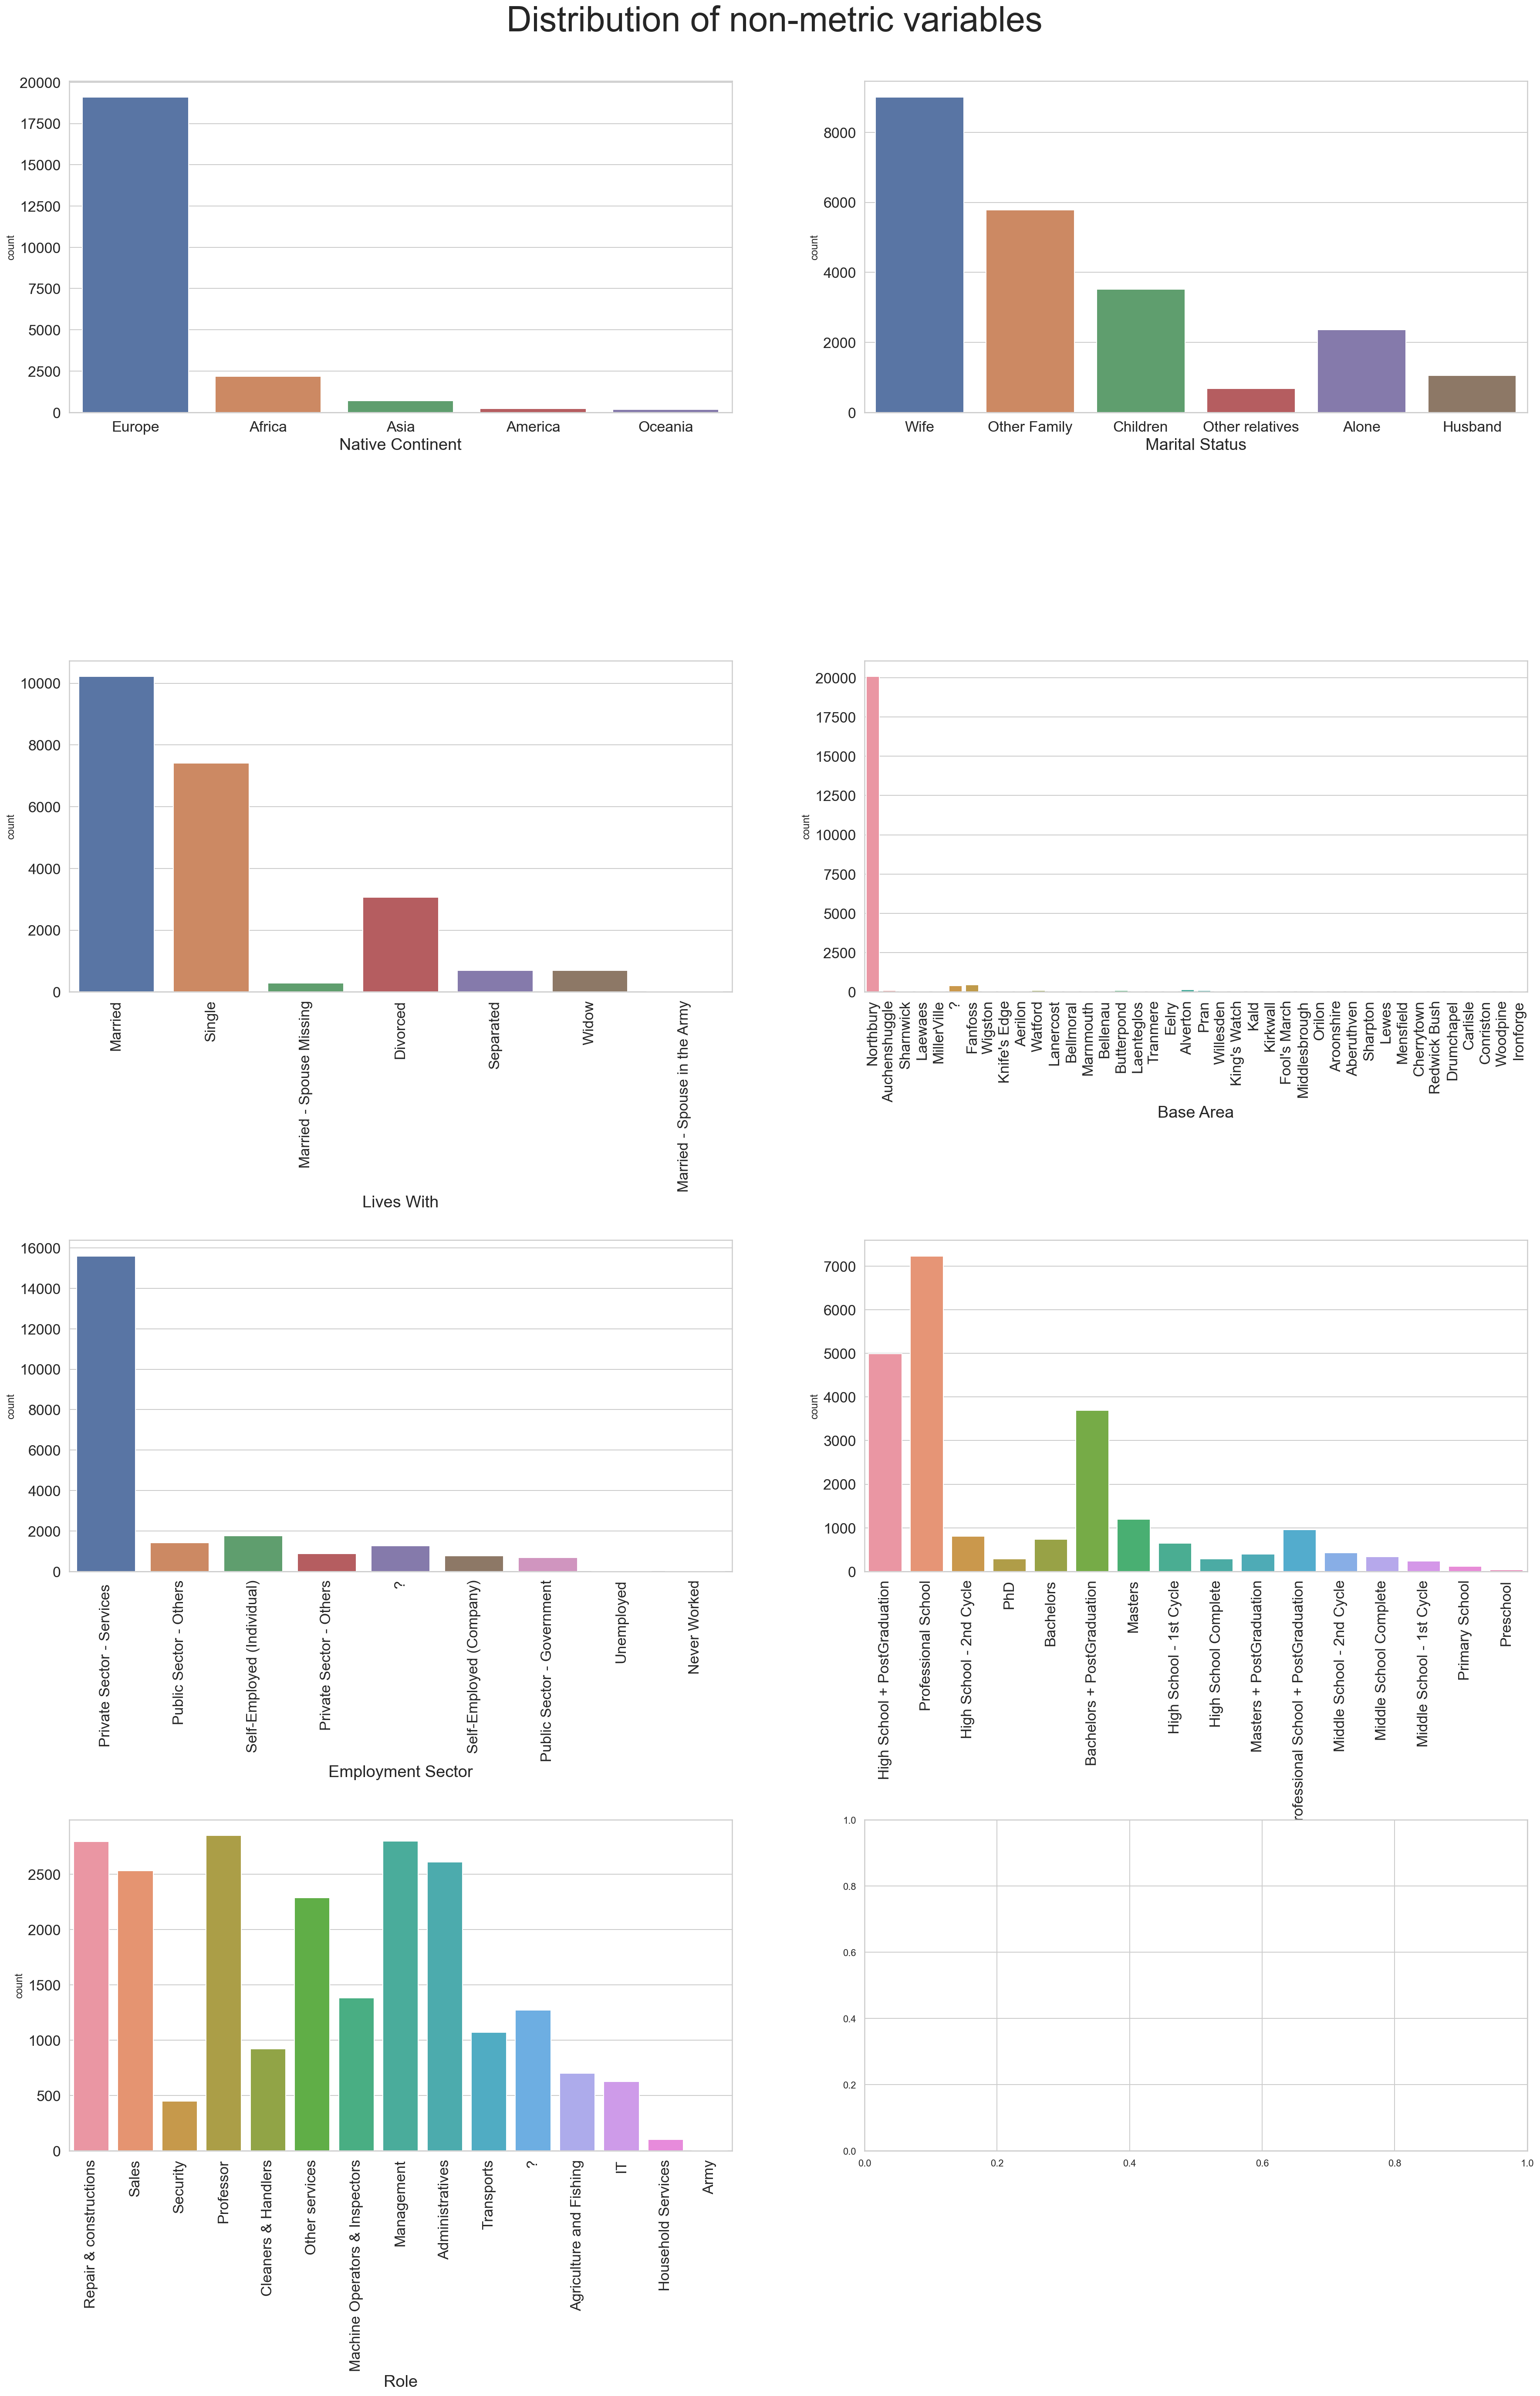

In [10]:
# Funciona
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30,40))

ax1=sns.countplot(non_metric["Native Continent"], ax=axes[0,0])
ax2=sns.countplot(non_metric["Lives with"], ax=axes[0,1])
ax3=sns.countplot(non_metric["Marital Status"], ax=axes[1,0])
ax4=sns.countplot(non_metric["Base Area"], ax=axes[1,1])
ax5=sns.countplot(non_metric["Employment Sector"], ax=axes[2,0])
ax6=sns.countplot(non_metric["Education Level"], ax=axes[2,1])
ax7=sns.countplot(non_metric["Role"], ax=axes[3,0])
# ax8=sns.countplot(non_metric["Birthday"], ax=axes[3,1])

ax1.tick_params(labelsize=17)
ax1.set_xlabel(xlabel='Native Continent',fontsize = 19)

ax2.tick_params(labelsize=17)
ax2.set_xlabel(xlabel='Marital Status',fontsize = 19)

ax3.tick_params(labelsize=17)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
ax3.set_xlabel(xlabel='Lives With',fontsize = 19)

ax4.tick_params(labelsize=17)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
ax4.set_xlabel(xlabel='Base Area',fontsize = 19)

ax5.tick_params(labelsize=17)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
ax5.set_xlabel(xlabel='Employment Sector',fontsize = 19)

ax6.tick_params(labelsize=17)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=90)
ax6.set_xlabel(xlabel='Education Level',fontsize = 19)

ax7.tick_params(labelsize=17)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=90)
ax7.set_xlabel(xlabel='Role',fontsize = 19)

# ax8.tick_params(labelsize=17)
# ax8.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax8.set_xlabel(xlabel='Birthday',fontsize = 19)

plt.subplots_adjust(top=0.95,hspace=0.75)
plt.suptitle("Distribution of non-metric variables", fontsize=40)

In [11]:
# Looking at the plots above, we can see the distribution of the values per category, for each categorical variables.
# With this, we see that there are 3 variables containing "?" as a value, which we understand are be null values
# So, here we are replacing those ? for null values, to analyze them more efficiently
df_train=df_train.replace('?', np.nan)

In [12]:
# Now we can already see how many missing values each variable has
df_train.isna().sum()

Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
dtype: int64

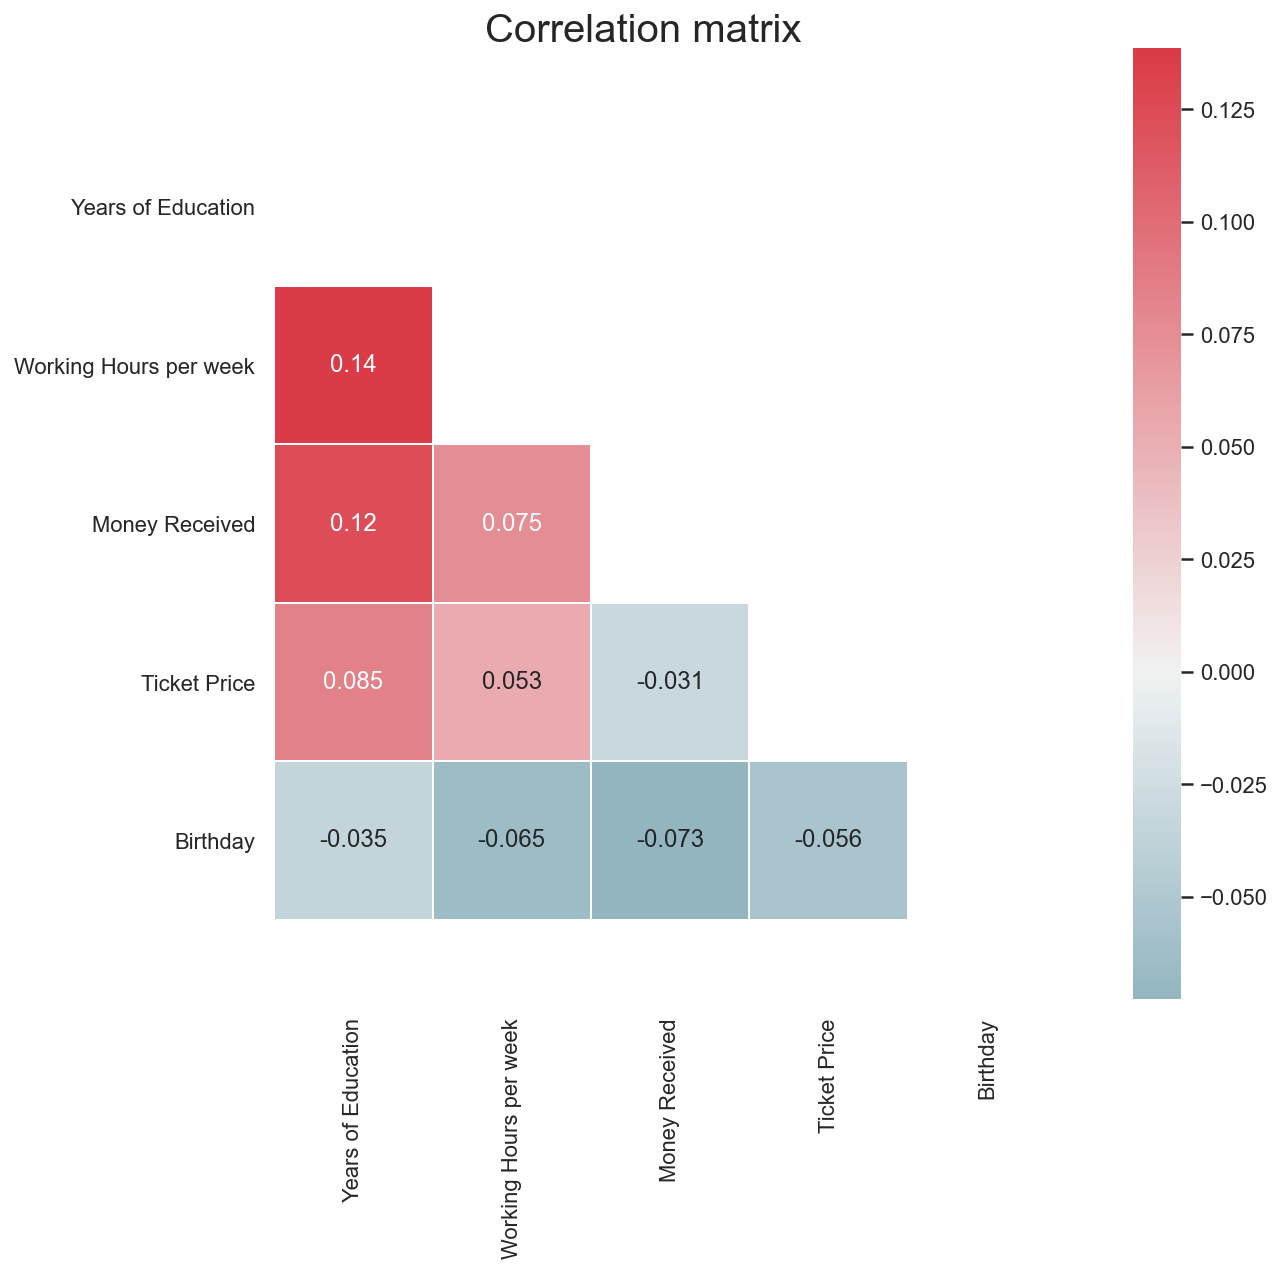

In [13]:
#inutil mas func
sns.set(style="white")

# Compute the correlation matrix
corr = metric.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax, annot=True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [14]:
pd.set_option('display.max_rows', 500)
df_train.groupby(["Base Area","Role"])["Role"].count()

Base Area      Role                          
Aberuthven     Administratives                      5
               Cleaners & Handlers                  3
               Household Services                   1
               IT                                   1
               Machine Operators & Inspectors       4
               Other services                       2
               Professor                            1
               Repair & constructions               4
               Sales                                2
Aerilon        Administratives                      2
               Agriculture and Fishing              1
               Cleaners & Handlers                  6
               Household Services                   1
               IT                                   2
               Machine Operators & Inspectors       6
               Management                           3
               Other services                       1
               Professor            

In [15]:
pd.crosstab(df_train['Base Area'], df_train['Role'],  margins = True)

Role,Administratives,Agriculture and Fishing,Army,Cleaners & Handlers,Household Services,IT,Machine Operators & Inspectors,Management,Other services,Professor,Repair & constructions,Sales,Security,Transports,All
Base Area,,,,,,,,,,,,,,,
Aberuthven,5,0,0,3,1,1,4,0,2,1,4,2,0,0,23
Aerilon,2,1,0,6,1,2,6,3,1,6,9,3,0,3,43
Alverton,28,3,0,4,1,9,10,9,22,19,6,13,2,1,127
Aroonshire,7,1,0,3,1,0,6,14,8,7,4,6,0,6,63
Auchenshuggle,3,2,0,7,5,0,4,2,29,4,14,5,0,3,78
Bellenau,0,0,0,0,0,0,2,3,0,2,0,0,1,0,8
Bellmoral,6,0,0,2,1,1,6,2,5,3,8,2,0,2,38
Butterpond,14,0,0,4,0,1,5,12,3,26,9,9,4,3,90
Carlisle,4,0,0,0,0,2,2,1,3,1,2,1,0,1,17


In [16]:
pd.crosstab(df_train['Marital Status'], df_train['Lives with'], margins=True)

Lives with,Alone,Children,Husband,Other Family,Other relatives,Wife,All
Marital Status,,,,,,,
Divorced,1113,227,0,1657,75,0,3072
Married,0,73,1042,12,85,9007,10219
Married - Spouse Missing,85,33,0,141,25,0,284
Married - Spouse in the Army,0,1,7,0,1,5,14
Separated,302,69,0,289,39,0,699
Single,607,3106,0,3281,422,0,7416
Widow,255,10,0,397,34,0,696
All,2362,3519,1049,5777,681,9012,22400


## Coherence Checks

In [17]:
# Check if there is anyone born after the year of this experiment (2048)
df_train[metric.Birthday>2048]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,


In [18]:
# Check the oldest year of birth and most recent one
print(metric.Birthday.min(),metric.Birthday.max())

1958 2031


In [19]:
# Check if there are negative amounts of money
df_train[(df_train["Money Received"]<0)|(df_train["Ticket Price"]<0)]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,


In [20]:
# Check if there is anyone who paid for the ticket and at the same time received money to join the experiment
df_train[(df_train["Ticket Price"]!=0) & (df_train["Money Received"]!=0)]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,


In [21]:
# Check if there is anyone with a certain level of education and years of education that don't match at al
df_train.groupby(["Education Level","Years of Education"] )["Years of Education"].mean()

Education Level                       Years of Education
Bachelors                             15                    15
Bachelors + PostGraduation            16                    16
High School + PostGraduation          13                    13
High School - 1st Cycle               10                    10
High School - 2nd Cycle               11                    11
High School Complete                  12                    12
Masters                               17                    17
Masters + PostGraduation              18                    18
Middle School - 1st Cycle             6                      6
Middle School - 2nd Cycle             8                      8
Middle School Complete                9                      9
PhD                                   21                    21
Preschool                             2                      2
Primary School                        4                      4
Professional School                   12                    1

In [22]:
# Check if there is anyone whose marital status seems incoherent with the person he/she lives with someone
df_train.groupby(["Marital Status","Lives with"] )["Lives with"].count()

Marital Status                Lives with     
Divorced                      Alone              1113
                              Children            227
                              Other Family       1657
                              Other relatives      75
Married                       Children             73
                              Husband            1042
                              Other Family         12
                              Other relatives      85
                              Wife               9007
Married - Spouse Missing      Alone                85
                              Children             33
                              Other Family        141
                              Other relatives      25
Married - Spouse in the Army  Children              1
                              Husband               7
                              Other relatives       1
                              Wife                  5
Separated                     Alone 

In [23]:
# Check if there is anyone with more years of education than his/her age
df_train[df_train.Birthday.map(lambda x: 2048-x.year)<(df_train["Years of Education"]+5)]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
14941,Miss Yvonne Henderson,2029-03-25,Africa,Single,Children,Lanercost,Bachelors + PostGraduation,16,NaN,NaN,40,0,0
16528,Miss Ava Glover,2028-07-15,Africa,Single,Other relatives,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Sales,30,0,0
24242,Miss Pippa Anderson,2024-02-01,Europe,Single,Other Family,Fool's March,PhD,21,Private Sector - Others,Professor,99,0,0
24843,Mr. Gavin Thomson,2028-09-13,Europe,Single,Children,Northbury,Masters,17,Private Sector - Services,Management,25,0,0
27833,Miss Sue Randall,2030-04-08,Europe,Single,Children,Northbury,Masters,17,Public Sector - Others,Professor,60,0,0
28849,Mr. Jonathan Oliver,2031-02-05,Europe,Single,Children,Northbury,High School + PostGraduation,13,Private Sector - Services,Administratives,20,0,0
33939,Mr. Isaac Alsop,2027-04-20,Europe,Single,Children,Northbury,Masters,17,Private Sector - Others,Transports,15,0,0


## Outliers

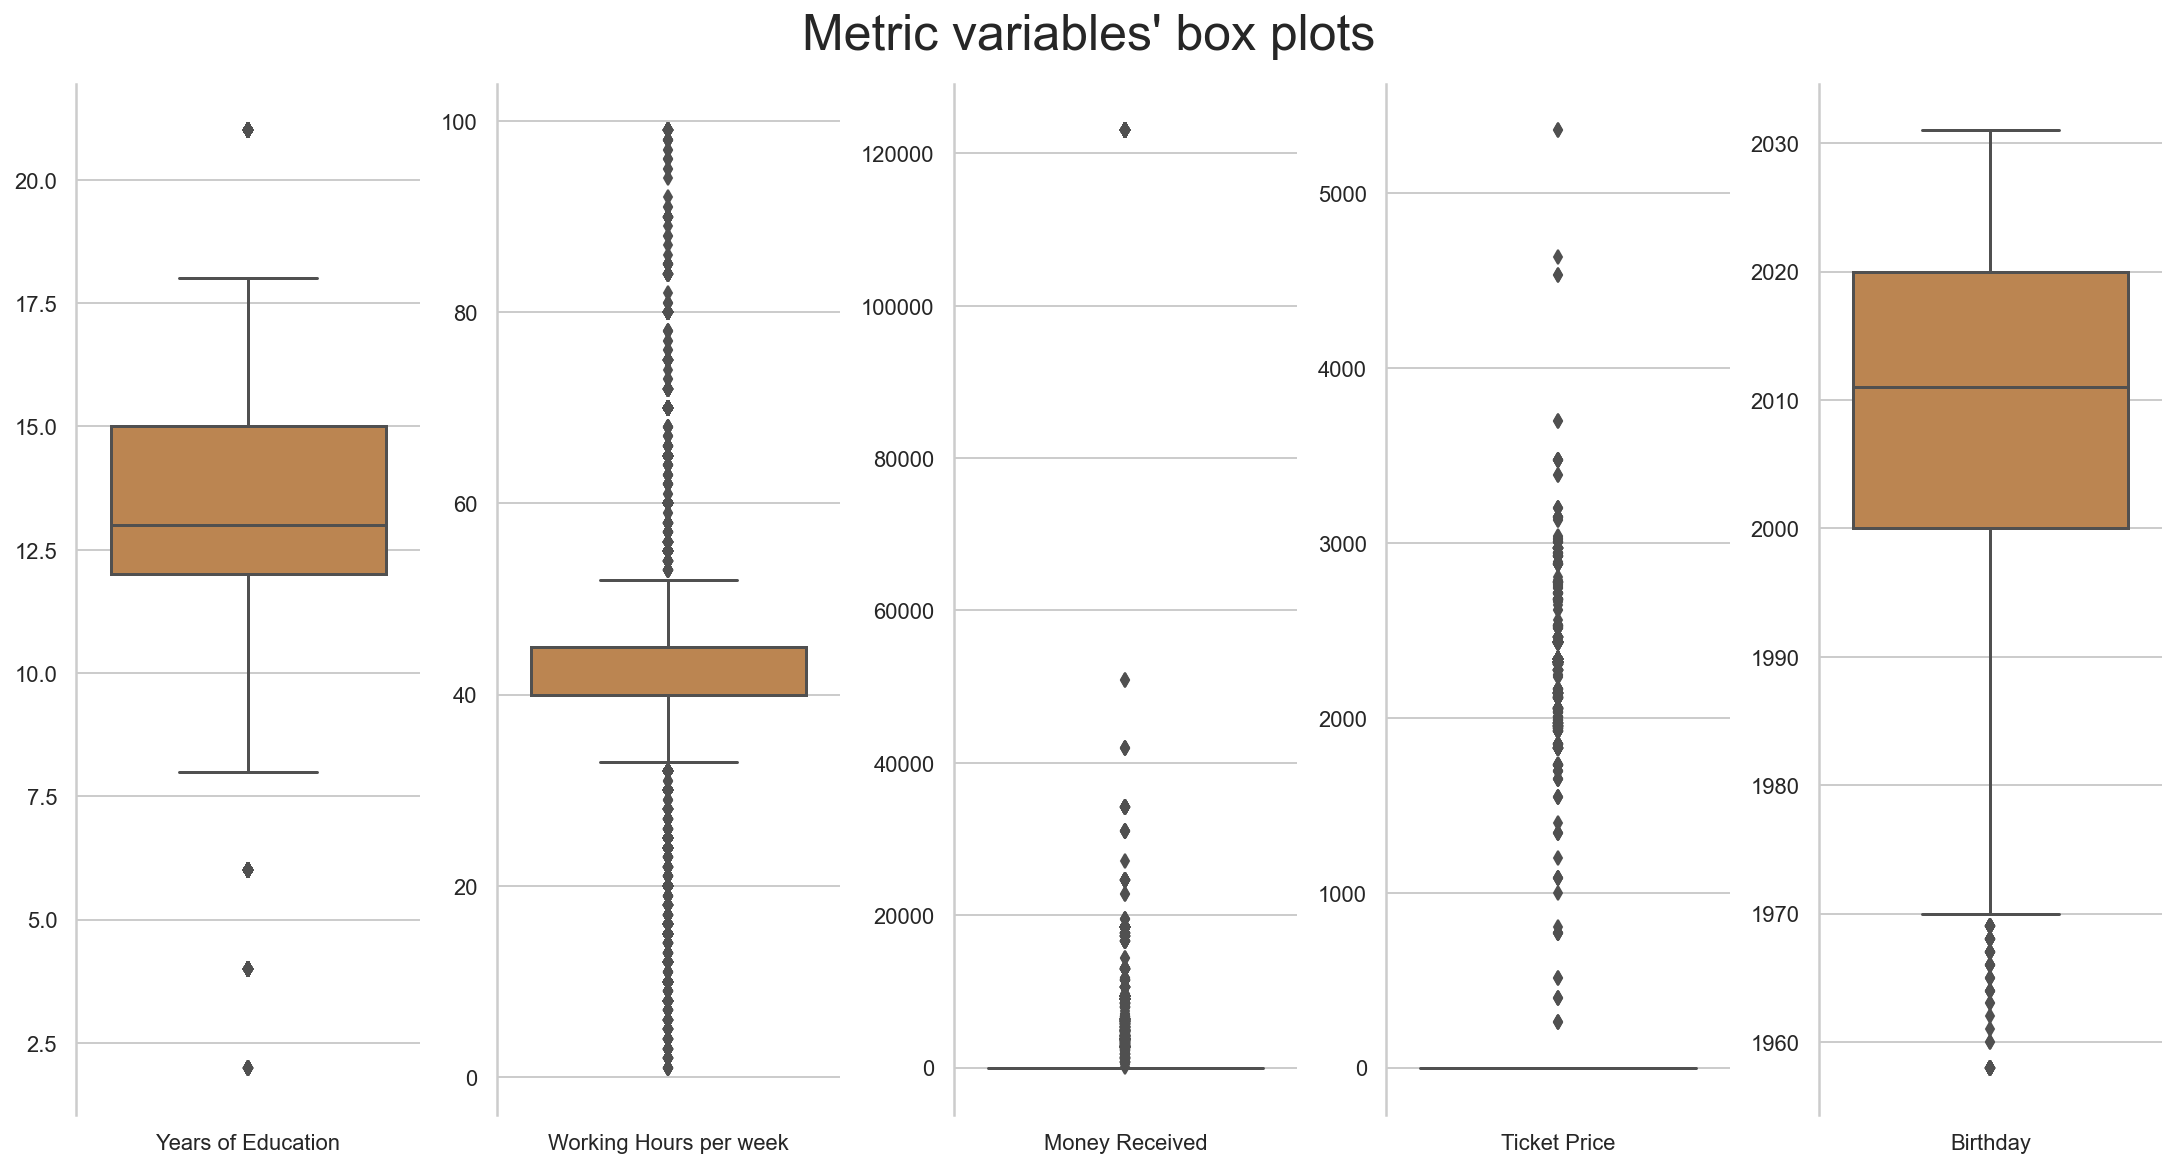

In [24]:
sns.set(style="whitegrid")

data = pd.melt(metric)
plot_features = metric.columns

#Prepare figure layout
fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)
    
# Draw the boxplots
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0], color='peru')
    i[0].set_xlabel("")
    i[0].set_ylabel("")

# Finalize the plot
plt.suptitle("Metric variables' box plots", fontsize=25)
sns.despine(bottom=True)

plt.show()

In [25]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=500)
clf.fit_predict(metric)

clf.negative_outlier_factor_

array([-0.97200037, -0.99607547, -0.99113981, ..., -1.09964512,
       -1.70687723, -0.95673496])

In [26]:
df_train[df_train["Years of Education"]==2]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
13008,Mr. Isaac Rampling,2023-08-09,Europe,Single,Other Family,Fanfoss,Preschool,2,Private Sector - Services,Agriculture and Fishing,35,0,0
14801,Mr. Stewart Piper,1994-06-09,Asia,Married,Wife,Sharnwick,Preschool,2,Private Sector - Services,Repair & constructions,40,0,0
15773,Mr. Julian Greene,2008-08-15,Europe,Married,Wife,Fanfoss,Preschool,2,Private Sector - Services,Other services,40,0,2057
16989,Miss Elizabeth Butler,2024-05-29,Europe,Single,Children,Northbury,Preschool,2,Private Sector - Services,Machine Operators & Inspectors,30,0,0
17052,Mrs. Bella Davidson,2000-09-14,Europe,Separated,Alone,Auchenshuggle,Preschool,2,Private Sector - Services,Other services,40,0,0
17344,Mr. Adrian Chapman,2022-08-13,Europe,Married - Spouse Missing,Other Family,Fanfoss,Preschool,2,Private Sector - Services,Machine Operators & Inspectors,40,0,2114
17626,Mr. Julian Scott,2029-04-19,Europe,Single,Other Family,MillerVille,Preschool,2,Private Sector - Services,Agriculture and Fishing,36,0,0
18822,Miss Carolyn Rees,1995-04-17,Europe,Single,Other Family,Northbury,Preschool,2,Public Sector - Others,Machine Operators & Inspectors,35,0,0
19274,Mr. Jack Sutherland,1985-07-09,Oceania,Married,Wife,Fanfoss,Preschool,2,Private Sector - Services,Professor,30,0,0


## Missing Values

#### 1st method

In [27]:
df_train1=df_train.copy()

In [28]:
modes = non_metric.mode().loc[0]
df_train1.fillna(modes, inplace=True)
df_train1.isna().sum()

Name                      0
Birthday                  0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
dtype: int64

#### 2nd method 

In [29]:
# understand if certain non-numeric variables are dependent or not from the ones with missing values

In [30]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# FIRST: Marital Status

# contingency table
marital_role=pd.crosstab(df_train['Marital Status'], df_train['Role'], margins=False).values

stat, p, dof, expected = chi2_contingency(marital_role)
#print('dof=%d' % dof)
#print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('[Marital Status] and [Role] are Dependent (reject H0)')
else:
    print('[Marital Status] and [Role] are Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('[Marital Status] and [Role] are Dependent (reject H0)')
else:
    print('[Marital Status] and [Role] are Independent (fail to reject H0)')

probability=0.950, critical=99.617, stat=2131.333
[Marital Status] and [Role] are Dependent (reject H0)
significance=0.050, p=0.000
[Marital Status] and [Role] are Dependent (reject H0)


In [31]:
# FIRST: Marital Status

marital_base=pd.crosstab(df_train['Marital Status'], df_train['Base Area'], margins=False).values

stat, p, dof, expected = chi2_contingency(marital_base)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('[Marital Status] and [Base Area] are Dependent (reject H0)')
else:
    print('[Marital Status] and [Base Area] are Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('[Marital Status] and [Base Area] are Dependent (reject H0)')
else:
    print('[Marital Status] and [Base Area] are Independent (fail to reject H0)')

probability=0.950, critical=264.224, stat=707.714
[Marital Status] and [Base Area] are Dependent (reject H0)
significance=0.050, p=0.000
[Marital Status] and [Base Area] are Dependent (reject H0)


In [32]:
# FIRST: Marital Status

marital_employment=pd.crosstab(df_train['Marital Status'], df_train['Employment Sector'], margins=False).values

stat, p, dof, expected = chi2_contingency(marital_employment)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('[Marital Status] and [Employment Sector] are Dependent (reject H0)')
else:
    print('[Marital Status] and [Employment Sector] are Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('[Marital Status] and [Employment Sector] are Dependent (reject H0)')
else:
    print('[Marital Status] and [Employment Sector] are Independent (fail to reject H0)')

probability=0.950, critical=58.124, stat=798.754
[Marital Status] and [Employment Sector] are Dependent (reject H0)
significance=0.050, p=0.000
[Marital Status] and [Employment Sector] are Dependent (reject H0)


In [33]:
# SECOND: Education Level

educ_role=pd.crosstab(df_train['Education Level'], df_train['Role'], margins=False).values

stat, p, dof, expected = chi2_contingency(educ_role)
# interpret test-statistic
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('[Education Level] and [Role] are Dependent (reject H0)')
else:
    print('[Education Level] and [Role] are Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('[Education Level] and [Role] are Dependent (reject H0)')
else:
    print('[Education Level] and [Role] are Independent (fail to reject H0)')

probability=0.950, critical=58.124, stat=10683.369
[Education Level] and [Role] are Dependent (reject H0)
significance=0.050, p=0.000
[Education Level] and [Role] are Dependent (reject H0)


In [34]:
# SECOND: Education Level

educ_base=pd.crosstab(df_train['Education Level'], df_train['Base Area'], margins=False).values

stat, p, dof, expected = chi2_contingency(educ_base)
# interpret test-statistic
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('[Education Level] and [Base Area] are Dependent (reject H0)')
else:
    print('[Education Level] and [Base Area] are Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('[Education Level] and [Base Area] are Dependent (reject H0)')
else:
    print('[Education Level] and [Base Area] are Independent (fail to reject H0)')

probability=0.950, critical=58.124, stat=6057.678
[Education Level] and [Base Area] are Dependent (reject H0)
significance=0.050, p=0.000
[Education Level] and [Base Area] are Dependent (reject H0)


In [35]:
# SECOND: Education Level

educ_employment=pd.crosstab(df_train['Education Level'], df_train['Employment Sector'], margins=False).values

stat, p, dof, expected = chi2_contingency(educ_employment)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('[Education Level] and [Employment Sector] are Dependent (reject H0)')
else:
    print('[Education Level] and [Employment Sector] are Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('[Education Level] and [Employment Sector] are Dependent (reject H0)')
else:
    print('[Education Level] and [Employment Sector] are Independent (fail to reject H0)')

probability=0.950, critical=129.918, stat=1544.322
[Education Level] and [Employment Sector] are Dependent (reject H0)
significance=0.050, p=0.000
[Education Level] and [Employment Sector] are Dependent (reject H0)


In [53]:
df_train2=df_train.copy()

In [ ]:
exp=df_train2[df_train2['Base Area'].isnull()].reset_index()

gr=df_train2.groupby(["Education Level","Marital Status"])['Base Area'].agg(pd.Series.mode)

In [63]:
# if there are null values in the group by, replace them by the overall mode of the orginal variable
for i in range(len(gr)):
    if len(gr[i])==0:
        gr[i]=df_train2['Base Area'].mode()[0]
    

# define the values of base area in the new auxiliary dataset as the mode of the base are values for the observations with the
# same level of education and marital status, because at least to some extent, they are more similar than the others       
for i in range(len(exp)):
    for x in range(len(gr)):
        if (exp['Education Level'][i]==gr.index[x][0]) and (exp['Marital Status'][i]==gr.index[x][1]):
            exp['Base Area'][i]=gr[x]

<ipython-input-63-83b301f61ef5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['Base Area'][i]=gr[x]


In [64]:
# if it's bimodal (has more than one mode, keep only the first one provided)
for i in range(len(exp)):
    if type(exp['Base Area'][i])!=str:
        exp['Base Area'][i]=df_train2['Base Area'].mode()[0]

# finally, replace the null values in Base Area in the original dataset by the values acquired before
for i in range(len(exp)):
    df_train2.loc[exp['CITIZEN_ID'][i],'Base Area']=exp['Base Area'][i]

<ipython-input-64-ee652907cc9b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['Base Area'][i]=df_train2['Base Area'].mode()[0]


In [ ]:
# Same process for Employment Sector

In [67]:
# first store a new dataframe containing only the observations where the Employment Sector is null
exp=df_train2[df_train2['Employment Sector'].isnull()].reset_index()

# store the groupby aggregation done based on Education Level and Marital Status
gr=df_train2.groupby(["Education Level","Marital Status"])['Employment Sector'].agg(pd.Series.mode)

In [69]:
# if the value of a groupby is null, replace it by the overall mode of the original variable
for i in range(len(gr)):
    if len(gr[i])==0:
        gr[i]=df_train2['Employment Sector'].mode()[0]


# define the values of employment sector in the new auxiliary dataset as the mode of the base are values for the observations with the
# same level of education and marital status, because at least to some extent, they are more similar than the others  
for i in range(len(exp)):
    for x in range(len(gr)):
        if (exp['Education Level'][i]==gr.index[x][0]) and (exp['Marital Status'][i]==gr.index[x][1]):
            exp['Employment Sector'][i]=gr[x]

<ipython-input-69-c1cbc32428c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['Employment Sector'][i]=gr[x]


In [70]:
# if it's bimodal (has more than one mode, keep only the first one provided)
for i in range(len(exp)):
    if type(exp['Employment Sector'][i])!=str:
        exp['Employment Sector'][i]=df_train2['Employment Sector'].mode()[0]
        
# finally, replace the null values in Employment Sector in the original dataset by the values acquired before        
for i in range(len(exp)):
    df_train2.loc[exp['CITIZEN_ID'][i],'Employment Sector']=exp['Employment Sector'][i]

<ipython-input-70-286ee58721de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['Employment Sector'][i]=df_train2['Employment Sector'].mode()[0]


In [ ]:
# Same process for Role

In [71]:
# first store a new dataframe containing only the observations where the Role is null
exp=df_train2[df_train2['Role'].isnull()].reset_index()

# store the groupby aggregation done based on Education Level and Marital Status
gr=df_train2.groupby(["Education Level","Marital Status"])['Role'].agg(pd.Series.mode)

In [72]:
# if the value of a groupby is null, replace it by the overall mode of the original variable
for i in range(len(gr)):
    if len(gr[i])==0:
        gr[i]=df_train2['Role'].mode()[0]

# define the values of role in the new auxiliary dataset as the mode of the base are values for the observations with the
# same level of education and marital status, because at least to some extent, they are more similar than the others  
for i in range(len(exp)):
    for x in range(len(gr)):
        if (exp['Education Level'][i]==gr.index[x][0]) and (exp['Marital Status'][i]==gr.index[x][1]):
            exp['Role'][i]=gr[x]

<ipython-input-72-f97db41ac906>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['Role'][i]=gr[x]


In [73]:
# if it's bimodal (has more than one mode, keep only the first one provided)
for i in range(len(exp)):
    if type(exp['Role'][i])!=str:
        exp['Role'][i]=df_train2['Role'].mode()[0]
        
# finally, replace the null values in Role in the original dataset by the values acquired before        
for i in range(len(exp)):
    df_train2.loc[exp['CITIZEN_ID'][i],'Role']=exp['Role'][i]

<ipython-input-73-5b9d51d04516>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['Role'][i]=df_train2['Role'].mode()[0]


In [74]:
df_train2.isna().sum()

Name                      0
Birthday                  0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
dtype: int64

/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

Text(0.5, 0.98, 'Distribution of non-metric variables')

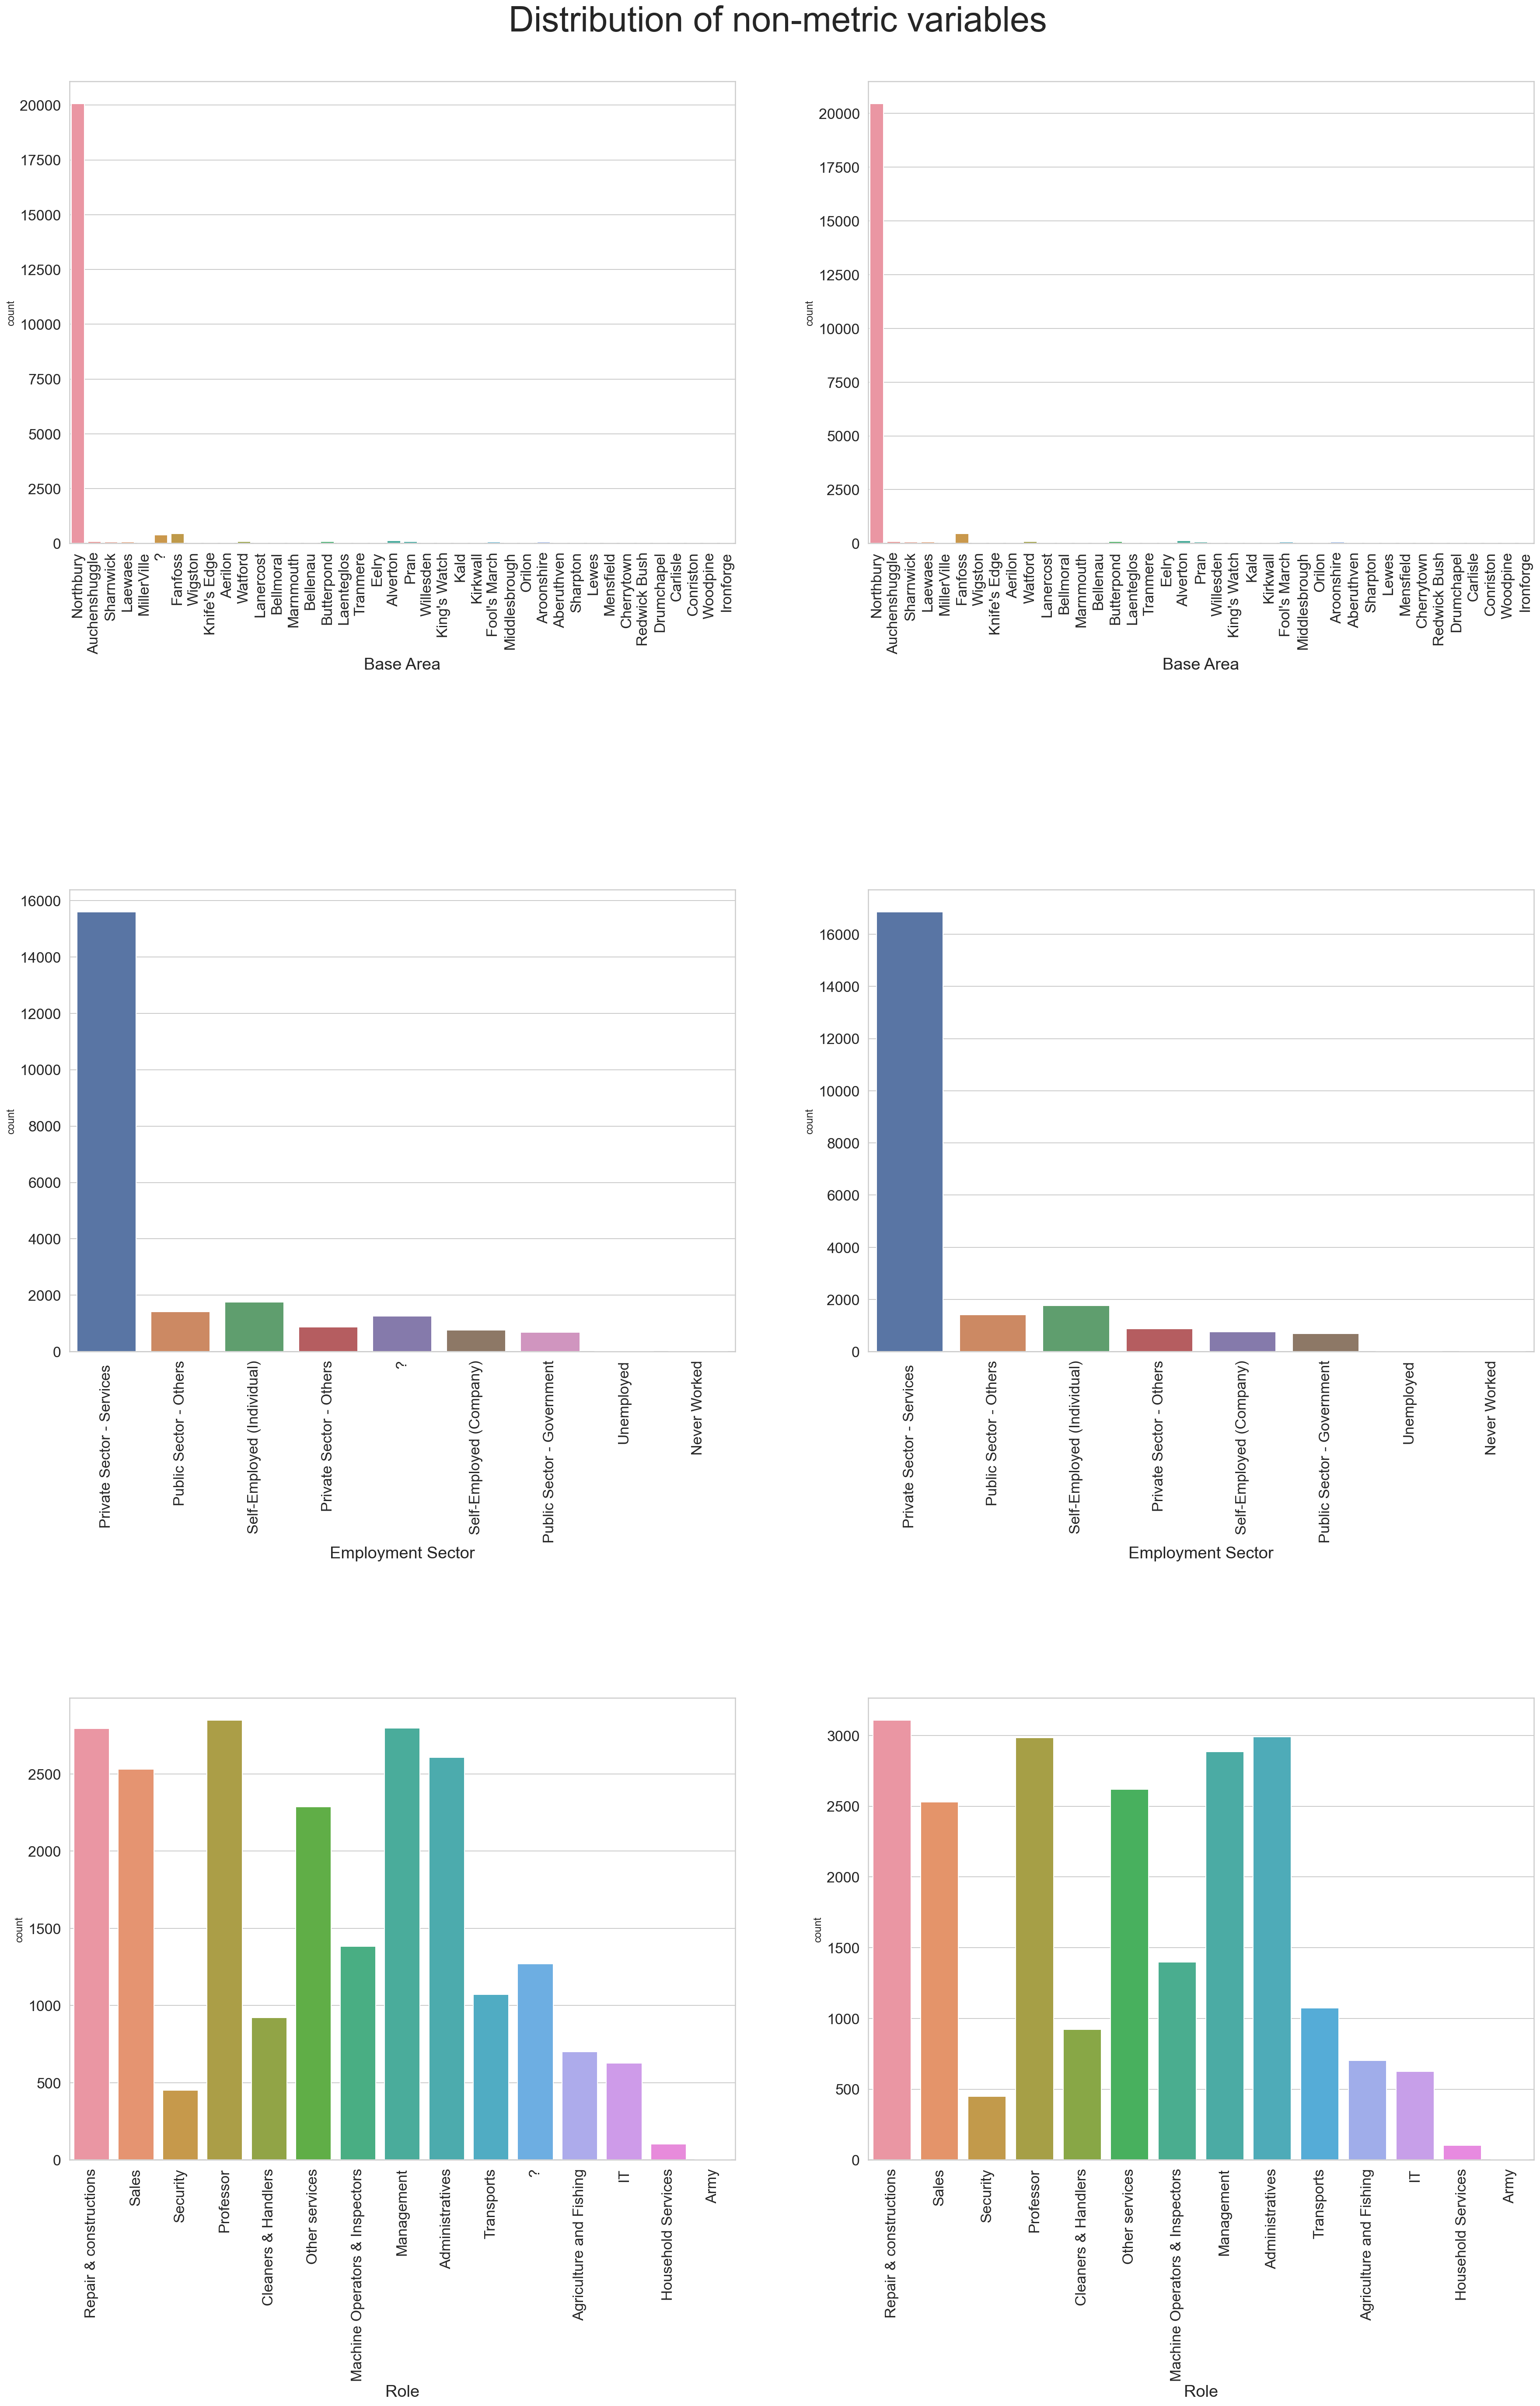

In [88]:
# Funciona
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30,40))


axa=sns.countplot(df_train2["Base Area"], ax=axes[0,1])
axb=sns.countplot(df_train2["Employment Sector"], ax=axes[1,1])
axc=sns.countplot(df_train2["Role"], ax=axes[2,1])

ax4=sns.countplot(non_metric["Base Area"], ax=axes[0,0])
ax5=sns.countplot(non_metric["Employment Sector"], ax=axes[1,0])
ax7=sns.countplot(non_metric["Role"], ax=axes[2, 0])


axa.tick_params(labelsize=17)
axa.set_xticklabels(axa.get_xticklabels(), rotation=90)
axa.set_xlabel(xlabel='Base Area',fontsize = 19)

ax4.tick_params(labelsize=17)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
ax4.set_xlabel(xlabel='Base Area',fontsize = 19)

axb.tick_params(labelsize=17)
axb.set_xticklabels(axb.get_xticklabels(), rotation=90)
axb.set_xlabel(xlabel='Employment Sector',fontsize = 19)

ax5.tick_params(labelsize=17)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
ax5.set_xlabel(xlabel='Employment Sector',fontsize = 19)

axc.tick_params(labelsize=17)
axc.set_xticklabels(axc.get_xticklabels(), rotation=90)
axc.set_xlabel(xlabel='Role',fontsize = 19)

ax7.tick_params(labelsize=17)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=90)
ax7.set_xlabel(xlabel='Role',fontsize = 19)

plt.subplots_adjust(top=0.95,hspace=0.75)
plt.suptitle("Distribution of non-metric variables", fontsize=40)

#### 3rd method

In [90]:
df_train3=df_train.copy()

In [91]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

#instantiate both packages to use
encoder = OrdinalEncoder()
#imputer = KNN()
# create a list of categorical columns to iterate over
cat_cols = ['Role', "Employment Sector", "Base Area"]

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(df_train3[columns])

/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [92]:
imputer=KNNImputer(n_neighbors=5)
df_filled=imputer.fit_transform(df_train3[['Role', 'Base Area', 'Employment Sector']])

CITIZEN_ID
12486    10
12487    10
12488    11
12489    12
12490     9
         ..
34881     3
34882     8
34883     9
34884    10
34885    13
Name: Role, Length: 22400, dtype: object

## Feature Engineering

In [ ]:
df_train["Age"]=df_train.Birthday.map(lambda x: 2048-x.year)

In [ ]:
df_train['Gender'] = np.where(df_train.Name.str.contains('Mrs|Miss'), 'Female', 'Male')

In [ ]:
df_train.head()